# Homework 6 - Dimension Reduction

In this homework, we will work on some problems involving fitting and dimension reduction. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la

import scipy as sp

## Preamble

The following method will be used in the next problem. It generates noisy samples from a sphere.

In [3]:
def sample_noisy_sphere(n, **kw):
    """
    Sample n points uniformly at random from the l-sphere
    embedded in d dimensions.
    
    Add normal noise with variance sigma
    
    Arguments:
        n - number of samples
    
    Optional arguments:
        r - radius of circle (default 1.0)
        l - dimension of sphere (default l = 1 == circle)
        sigma - noise variance (default 0.1)
        d - dimension of embedded space (default l+1)
    """
    r = kw.get('r', 1.0)
    l = kw.get('l', 1)
    sigma = kw.get('sigma', 0.1)
    d = kw.get('d', l+1)

    X = np.random.randn(n,l+1)
    X = r * X / np.linalg.norm(X, axis=1).reshape(n, -1) # project onto sphere
    
    Q, R = np.linalg.qr(np.random.randn(d, l+1))
    X = X @ Q.T # apply random rotation

    return X + sigma*np.random.randn(n, d)

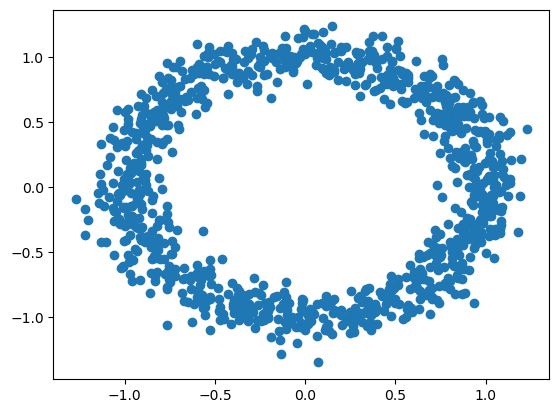

In [64]:
X = sample_noisy_sphere(1000, d=2)
plt.scatter(X[:,0], X[:,1])
plt.show()

## Problem 0 - Multidimensional Scaling (20 points)

[Mulitdimensional scaling (MDS)](https://en.wikipedia.org/wiki/Multidimensional_scaling) is a method which looks for an embedding of $n$ data points into a (lower-dimensional) Euclidean space that preserves pairwise distances as much as possible. In other words, given a set of data points $z_0,\dots,z_{n-1}$ and a distance function $d$ measuring the distance between them, then we want to find $x_0,\dots,x_{n-1} \in \mathbb{R}^k$ such that
$$\|x_i - x_j \| \approx d(z_i,z_j), \quad 0 \le i,j \le n-1.$$

First off, we note that if $N>k,$ generally it will not be possible to get equality (think about $(1,0,0,0,\dots),(0,1,0,0\dots),\cdots,$ but we want to get as close as possible.

---

Let's first start with the simple case where $d$ is the standard Euclidean distance and get some intuition. We can construct the matrix of pairwise distances, $D,$ by setting $D_{i,j} = d(z_i,z_j,)^2.$ Now, let's assume that there was an exact solution. So, there exist $x_1,\dots,x_{n-1} \in \mathbb{R}^k$ such that 
$$D_{i,j} = \|x_i-x_j\|^2,\quad 0 \le i,j \le {n-1}.$$
Let's set $X$ to be the $n\times k$ matrix whose $i$th row is $x_i.$ Then, 
$$D = \vec{1} w^T +w \vec{1}^T -2 X X^T$$
where $w = (\|x_0\|,\|x_2\| ,\dots, \|x_{n-1}\|)^T$ and $\vec{1}$ is the vector of all ones with length $n.$

From this, it is easy to see that $D$ will not change if we shift all $x_i$'s by the same vector (shifting every data point preserves pairwise distances), or rotate them all using an orthogonal matrix $Q,$ since those transformations preserve pairwise distances. So, if we want to recover the $x_i$'s from $D$ we can only do it up to a global translation and rotation. 

Thus, without loss of generality, we can "center" the matrix $X$ so that columns sum to 0, setting $Y = (I - \frac{1}{n}\vec{1}\vec{1}^T) X$.  Let's call this projection matrix $J = (I - \frac{1}{n}\vec{1}\vec{1}^T)$ the "centering matrix". In particular, note that $J \vec{1} = (I - \frac{1}{n}\vec{1}\vec{1}^T )\vec{1} = \vec{1} - \vec{1} = \vec{0}$, so the nullspace of $J$ consists of constant vectors, as expected.

The problem now is, given $D,$ find $Y$ up to a global rotation. Looking at the formula for $D,$ if the first two terms were not there, the problem would be easy. We would want to find an $n\times k$ matrix $X$ such that $D = -2 X X^T.$ This is nothing but a rank $k$ approximation to $D,$ and can be found using the eigendecomposition!

Let's see how to do this. If we define
\begin{equation}
B = -\frac{1}{2}J D J^T
\end{equation}
then, looking at the definition of $D,$ we see that
$$B = J X X^T J^T = YY^T.$$ 
Thus we can recover $Y=JX$ (up to a global rotation - i.e. the same rotation is applied to every data point) using an eigenvalue decomposition. Specifically, if $B = V \Lambda V^T$ then one solution for $Y$ is given by $Y=  V_k\Lambda^{1/2},$ where $V_k$ spans the largest $k$-dimensional eigenspace and $\Lambda_k$ is the diagonal matrix with the associated eigenvalues.

More generally, if the problem is not exactly solvable, we could try to solve the optimization problem
\begin{equation}
\mathop{\textsf{minimize}}_{Z} \|B - ZZ^T\|_F
\end{equation}
Where $X$ is the embedding coordinates (an $n\times k$ matrix), and $\|\cdot \|_F$ is the Frobenius matrix norm $\|A\|_F = \sqrt{\sum_{i,j} A_{i,j}^2}$.
As before, since $B$ and $ZZ^T$ are symmetric, an optimal solution is given by the optimal rank-$k$ approximation to $B$, which can again be computed using an eigenvalue decomposition
\begin{equation}
B = V \Lambda V^T
\end{equation}
And setting $Z = V_k \Lambda^{1/2}_k.$

Putting it altogether, we see that we have an algorithm for recovering a Euclidean embedding from the matrix of pairwise distances.  Note that there is nothing stopping us from finding a Euclidean embedding when $D$ does not come from Euclidean distances, but from some other metric.  In this case, the recovered $Z$ will give coordinates which "optimally" respect the original metric, even when the original metric can't be embedded in Euclidean space.

We now have an algorithm for data visualization given pairwise distance information, the classical MDS algorithm:
1. Form the matrix $D$ so $D_{i,j} = d(x_i, x_j)^2$ (even when the distance $d$ isn't Euclidean).
See [here](https://caam37830.github.io/book/08_geometry/distances.html#pairwise-distances) for helpful routines and pointers to more information.
2. Form the matrix $B = -\frac{1}{2} J D J^T$
3. Compute the eigenvalue decomposition $B = V\Lambda V^T$
4. Return a $k$-dimensional embedding $Z
= V_k \Lambda_k^{1/2}$ (recall that for `eigh` $V_k$ is the last `k` columns of the eigenvector matrix)

Finally, note there are a variety of variations to MDS.  The one we're implementing is probably the simplest.

### Part A - Center a Matrix (5 points)

Write a function `center_matrix(D)` which given a matrix $D$ returns the matrix $-\frac{1}{2} J D J^T$. You should make this code faster than simply forming $J$ and multiplying.

In [7]:
### PLACEHOLDER

def center_matrix(D):
    """
    "Centers" a matrix D, creating a matrix whose columns each sum to zero. 
    In particular, computes and returns a matrix B such that:
    B = -0.5 * J @ D @ J.T, where J = I - (1/n) * 1 @ 1.T, where 1 is the (n x 1) matrix of ones.

    Parameters:
    D: The matrix to be "centered."

    Returns:
    B: The "centered" matrix corresponding to D, computed as described above.
    """
    # Create the (n x n) ones matrix and the identity matrix of the appropriate sizes.
    n = D.shape[0]
    one = np.ones(shape = np.array([n,n]))
    identity = np.identity(n)

    # Compute the projection matrix J and the centered matrix B.
    J = identity - (1/n) * one
    B = -1/2 * J @ D @ J.T
    return B

# # Test
# D = np.array([[1, 1, 1],
#               [2, 2, 3],
#               [4, 5, 6]])
# print(center_matrix(D))



### ALTERNATIVE APPROACH -- Sometimes but not always faster??? ###

def center_matrix_2(D):
    """
    Alternate approach to "centering" a matrix D, creating a matrix
    whose columns each sum to zero.
    In particular, computes and returns a matrix B such that:
    B = -0.5 * (D - D@1@1.T/n - 1@1.T@D/n + 1@1.T@D@1@1.T/n^2), where 1 is the (n x 1) matrix of ones.

    Parameters:
    D: The matrix to be "centered."

    Returns:
    B: The "centered" matrix corresponding to D, computed as described above.

    Note: This method sometimes performs better than the above method (center_matrix()), but not always.
    """
    n = D.shape[0]
    one = np.ones(shape = np.array([n, n]))
    
    term0 = D
    term1 = (-1/n) * D @ one
    term2 = (-1/n) * one @ D
    term3 = (1/(n**2)) * one @ D @ one
    B = -1/2 * (term0 + term1 + term2 + term3)
    return B



# import time # to compute runtimes
# from tqdm import tqdm # progress bar

# # Timing borrowed/adapted from HW0
# if __name__ == '__main__':
#     """
#     this section of the code only executes when
#     this file is run as a script.
#     """
#     def get_runtimes(ns, method):
#         """
#         Compare efficiency of two centering approaches
#         """
#         ts = []
#         if method == 1:
#             for n in tqdm(ns):
#                 D = np.random.rand(3,3) * 100
#                 t0 = time.time()
#                 B = center_matrix(D)
#                 t1 = time.time()
#                 ts.append(t1 - t0)
#             return ts
#         elif method == 2:
#             for n in tqdm(ns):
#                 D = np.random.rand(3,3) * 100
#                 t0 = time.time()
#                 B = center_matrix_2(D)
#                 t1 = time.time()
#                 ts.append(t1 - t0)
#             return ts

# TEST
# ns = np.array([1, 2, 3])

# t1 = np.array(get_runtimes(ns, 1))
# t2 = np.array(get_runtimes(ns, 2))

# print(t2 - t1)

### Part B - Implement the MDS algorithm (5 points)

Write a function `MDS(D, k=2)` computes $B=-\frac{1}{2} J D J^T$, computes its eignvalue decomposition and then returns the `k`-dimensional Euclidean embedding for a matrix of pairwise distances `D`.

In [8]:
def MDS(D, k = 2):
    """
    Computes the k-dimensional embedding of points in > k dimensions whose distances are contained in D.

    Parameters:
    D: A matrix of pairwise squared distances between points.
    k: The dimension of the space in which the points whose distances are collected in D are embedded.

    Returns:
    Z: A k-dimensional embedding of the points whose distances are collected in D. Computed based on the
       eigendecomposition of B, the "centered" matrix corresponding to D.
    """
    # Computes B
    B = center_matrix(D)

    # Eigendecomposition
    Lambda_vec, V = la.eigh(B)

    # Extract the k largest eigenvalues of B and the corresponding eigenvectors
    Lambda_k_vec = Lambda_vec[-k:]
    Lambda_k_mat = np.diag(Lambda_k_vec)
    Vk = V[:, -k:]
    
    # Compute the k-dimensional embedding of the points
    Z = Vk @ np.sqrt(Lambda_k_mat)
    #Z = Vk @ la.sqrtm(Lambda_k_mat) --- Pretty sure the square rooting is elementwise
    return Z

# # Test
# D = np.array([[1, 1, 1],
#               [2, 2, 3],
#               [4, 5, 6]])

# print(MDS(D))

### Part C - Use your implementation (10 points)

Use the noisy circle data in the preamble section for your input data `X` with $d=20$ and $l=1$.  Use your `MDS` function with $k=2$ to get coordinates for the data after computing pairwise distances with the following metrics.  Visualize each embedding using a scatter plot.

1. Euclidean Metric
2. $L^1$ metric (`cityblock` in scipy)
3. $L^\infty$ metric (`chebyshev` in scipy)
4. Cosine distance (`cosine` in scipy)

How does the embedding depend on the choice of metric?

---------------------

The shapes of each embedding roughly correspond to the shape of 1-spheres using each metric. Indeed...
* A 1-sphere using the Euclidean metric is a circle. We see in the first image below that the embedding of our points in $\mathbb{R}^2$ forms a circle, but with a bit of noise.
* A 1-sphere using the $L^1$ metric is a square. We see in the second image below that the embedding of our points in $\mathbb{R}^2$ still has a round shape, but perhaps with slightly sharper edges at the northmost, southmost, eastmost, and westmost parts of the graph. This embedding also has more noise than when using the Euclidean metric.
* A 1-sphere using the $L^\infty$ metric is also a square. We see in the third image below that the embedding of our points in $\mathbb{R}^2$ has a distinctly rhombus-like (if not square-like) shape, with four sharp vertices.
* Lastly, cosine distance does best of all, creating a circular embedding of the data with very little noise. This makes sense: cosine distance is defined with respect to the cosine of the angle between two points, so it naturally preserves the curvature of a 2-sphere in $\mathbb{R}^{20}$ projected down into $\mathbb{R}^2$.

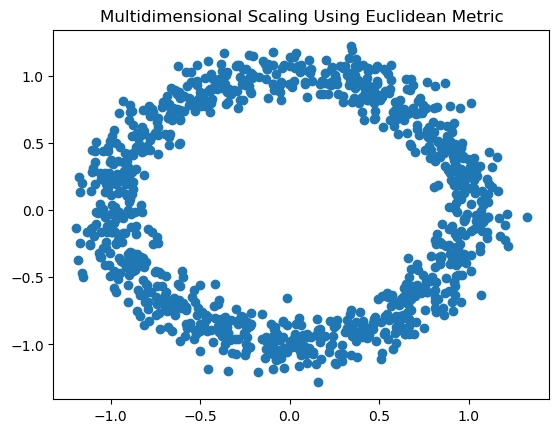

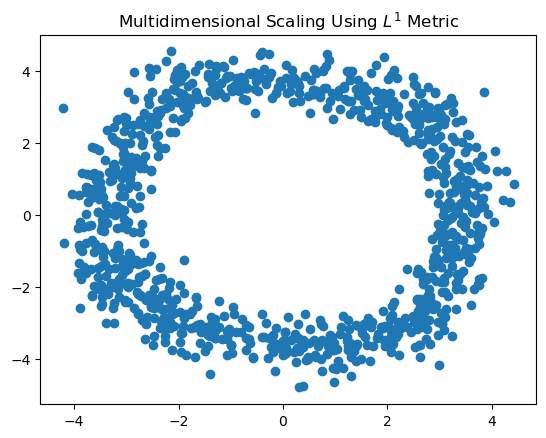

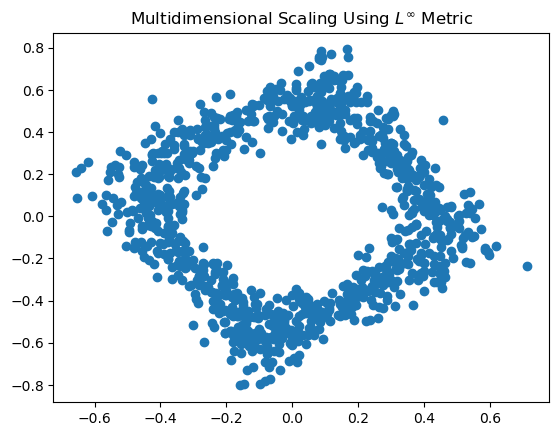

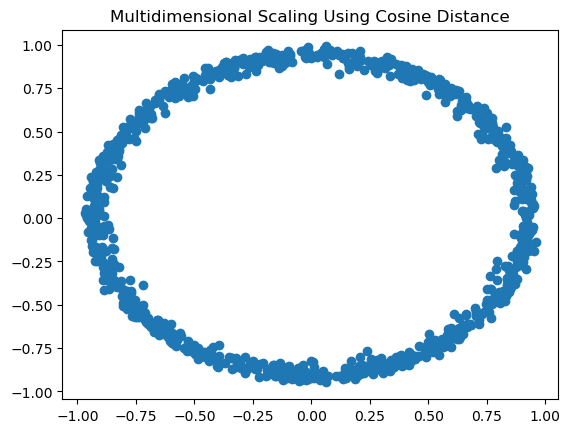

In [18]:
# Generate data: 1000 points from a 2-sphere (i.e., a three-dimensional sphere) embedded in R^20
X = sample_noisy_sphere(1000, d=20, l = 1)

# Euclidean Metric
D_euclidean = np.square(sp.spatial.distance.squareform(sp.spatial.distance.pdist(X, metric = "euclidean")))
Z_euclidean = MDS(D_euclidean)
plt.scatter(Z_euclidean[:,0], Z_euclidean[:,1])
plt.title("Multidimensional Scaling Using Euclidean Metric")
plt.show()

# L^1 Metric
D_cityblock = np.square(sp.spatial.distance.squareform(sp.spatial.distance.pdist(X, metric = "cityblock")))
Z_cityblock = MDS(D_cityblock)
plt.scatter(Z_cityblock[:,0], Z_cityblock[:,1])
plt.title(r"Multidimensional Scaling Using $L^1$ Metric")
plt.show()

# L^Infty Metric
D_chebyshev = np.square(sp.spatial.distance.squareform(sp.spatial.distance.pdist(X, metric = "chebyshev")))
Z_chebyshev = MDS(D_chebyshev)
plt.scatter(Z_chebyshev[:,0], Z_chebyshev[:,1])
plt.title(r"Multidimensional Scaling Using $L^\infty$ Metric")
plt.show()

# Cosine Distance
D_cosine = np.square(sp.spatial.distance.squareform(sp.spatial.distance.pdist(X, metric = "cosine")))
Z_cosine = MDS(D_cosine)
plt.scatter(Z_cosine[:,0], Z_cosine[:,1])
plt.title("Multidimensional Scaling Using Cosine Distance")
plt.show()


### Part D (5 points)
In this problem we explore how the underlying dimension of the data affects the output of the MDS algorithm.

Make some visualizations for 1-, 2-, and 5-spheres in $d=20$ dimensions. Is the two dimensional embedding of the 5-sphere informative?

-----------

* As shown in the first image below, embedding a 1-sphere (that is, a circle) from $\mathbb{R}^{20}$ into $\mathbb{R}^2$ is naturally seamless: our collection of points outlined a circle in $\mathbb{R}^{20}$, and they still outline an (approximate) circle in $\mathbb{R}^2$. To illustrate why a circle embedded in $\mathbb{R}^{20}$ easily translates to a circle embedded in $\mathbb{R}^2$, one can imagine a change of basis in $\mathbb{R}^{20}$ such that our original 1-sphere lies, unchanged, in a two-dimensional plane.

* As shown in the second image below, embedding a 2-sphere (that is, a sphere) from $\mathbb{R}^{20}$ into $\mathbb{R}^2$ yields an (approximate) circle, with some points mapped to its interior.

* Finally, as shown in the third image below, when we embed a 5-sphere from $\mathbb{R}^{20}$ into $\mathbb{R}^2$, we get a collection of points that is vaguely circular/disk-like, but with a boundary that is noticeably less defined than the 2-sphere above. This illustrates that collapsing a 5-sphere into just two dimensions does not make for a very informative visual: the structure of an object with many dimensions cannot be adequately captured in few dimensions.

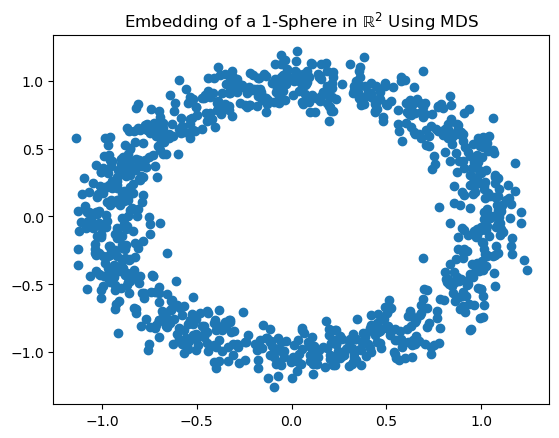

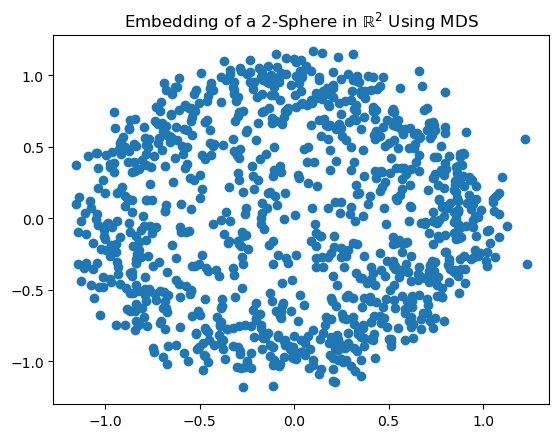

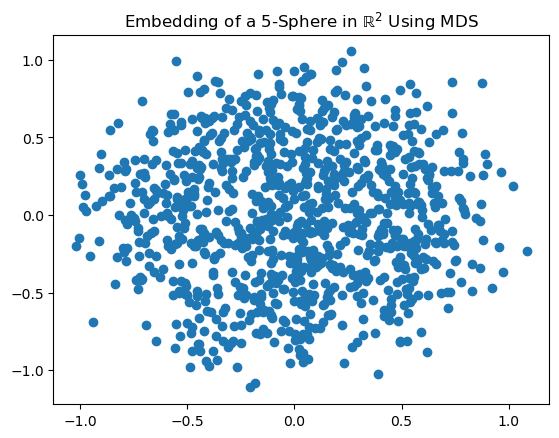

In [10]:
# 1-Sphere
X_1sphere = sample_noisy_sphere(1000, d=20, l = 1)
D_1sphere = np.square(sp.spatial.distance.squareform(sp.spatial.distance.pdist(X_1sphere, metric = "euclidean")))
Z_1sphere = MDS(D_1sphere)
plt.scatter(Z_1sphere[:,0], Z_1sphere[:,1])
plt.title(r"Embedding of a 1-Sphere in $\mathrm{\mathbb{R}}^2$ Using MDS")
plt.show()

# 2-Sphere
X_2sphere = sample_noisy_sphere(1000, d=20, l = 2)
D_2sphere = np.square(sp.spatial.distance.squareform(sp.spatial.distance.pdist(X_2sphere, metric = "euclidean")))
Z_2sphere = MDS(D_2sphere)
plt.scatter(Z_2sphere[:,0], Z_2sphere[:,1])
plt.title(r"Embedding of a 2-Sphere in $\mathrm{\mathbb{R}}^2$ Using MDS")
plt.show()

# 5-Sphere
X_5sphere = sample_noisy_sphere(1000, d=20, l = 5)
D_5sphere = np.square(sp.spatial.distance.squareform(sp.spatial.distance.pdist(X_5sphere, metric = "euclidean")))
Z_5sphere = MDS(D_5sphere)
plt.scatter(Z_5sphere[:,0], Z_5sphere[:,1])
plt.title(r"Embedding of a 5-Sphere in $\mathrm{\mathbb{R}}^2$ Using MDS")
plt.show()